In [1]:
# Para las mediciones realizadas en este trabajo

T_REAL_PHI_FILE = "../Mediciones/t1_pps_aligned.bin" 
REAL_PHI_FILE = "../Mediciones/real_phi.bin"
T_SIC_PHI_FILE = "../Mediciones/t1.bin"
REAL_PHI_INTERP_FILE = '../Mediciones/real_phi_interp.bin'
SIC_PHI_FILE = '../Mediciones/sic_phi.bin'
T_PPS_FILE = '../Mediciones/t1.bin'

# Para las mediciones realizadas en la tesis

# T_REAL_PHI_FILE = "../data/t1_pps_aligned.bin" 
# REAL_PHI_FILE = "../data/real_phi.bin"
# T_SIC_PHI_FILE = "../data/t1.bin"
# REAL_PHI_INTERP_FILE = "../data/real_phi_interp.bin"
# SIC_PHI_FILE = '../data/sic_phi.bin'
# T_PPS_FILE = '../data/t1.bin'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from calc_mtie import mtie_calc
import numpy as np
import matplotlib.pyplot as plt
from histogram_no_bins import *

Interpolamos el $\Phi$ real en los tiempos para los que calculamos el $\Phi$ con SIC:

In [3]:
t_real_phi = np.fromfile(T_REAL_PHI_FILE)
real_phi = np.fromfile(REAL_PHI_FILE)
t_sic_phi = np.fromfile(T_SIC_PHI_FILE)

real_phi = np.interp(t_sic_phi,t_real_phi,real_phi)

real_phi.tofile(REAL_PHI_INTERP_FILE)

In [4]:
real_phi = np.fromfile(REAL_PHI_INTERP_FILE)
sic_phi = np.fromfile(SIC_PHI_FILE)
t_pps = t_sic_phi

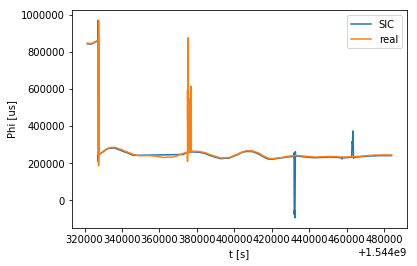

In [5]:
plt.plot(t_pps/1e6, sic_phi)
plt.plot(t_pps/1e6, real_phi)
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('SIC','real'));

In [6]:
te = sic_phi - real_phi

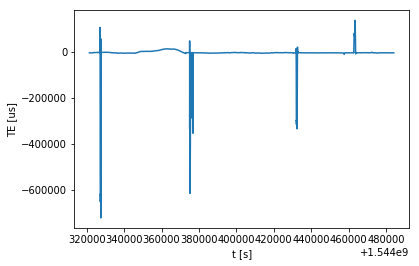

In [7]:
plt.plot(t_pps/1e6,te)
plt.xlabel('t [s]')
plt.ylabel('TE [us]');

In [8]:
tie, mtie60 = mtie_calc(te, 60)
tie, mtie120 = mtie_calc(te, 120)
tie, mtie180 = mtie_calc(te, 180)
tie, mtie300 = mtie_calc(te, 300)
mtie120 = mtie120/2
mtie180 = mtie180/3
mtie300 = mtie300/5

In [9]:
perc60 = np.percentile(mtie60, 90)
perc120 = np.percentile(mtie120, 90)
perc180 = np.percentile(mtie180, 90)
perc300 = np.percentile(mtie300, 90)
max_perc = max(perc60,perc120,perc180,perc300)

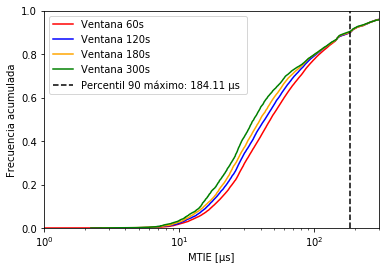

In [11]:
val60, hist60 = histogram_no_bins(mtie60)
val120, hist120 = histogram_no_bins(mtie120)
val180, hist180 = histogram_no_bins(mtie180)
val300, hist300 = histogram_no_bins(mtie300)

plt.plot(val60, hist60, c='red', label='Ventana 60s')
plt.plot(val120, hist120, c='blue', label='Ventana 120s')
plt.plot(val180, hist180, c='orange', label='Ventana 180s')
plt.plot(val300, hist300, c='green', label='Ventana 300s')

plt.ylim([0,1])
plt.xlim([1,300]);
plt.semilogx()
plt.xlabel('MTIE [μs]')
plt.ylabel('Frecuencia acumulada')


plt.axvline(x=max_perc, color='k', linestyle='--', label='Percentil 90 máximo:'+(' %.2f' % max_perc+' μs '))

plt.legend();
plt.savefig('mtie_sic.png')